# *Superdense Coding*

This notebook implements the superdense coding protocol using the [Quantum Experience](https://www.research.ibm.com/ibm-q/qx/).

## Introduction

Superdense coding is a protocol to transmit two classical bits of information using only one qubit. It was devised by Charles Bennett (IBM) and Stephen Wiesner in [1992](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.69.2881). 

The protocol starts out with a shared entangled state between the sender (Alice) and the receiver (Bob):
$$|\psi\rangle = \frac{1}{\sqrt{2}}(|0_A 0_B\rangle + |1_A 1_B\rangle)$$
The first qubit, denoted by subscript $A$, belongs to Alice and the second qubit, $B$, belongs to Bob.

Alice wants to send a two bit message to Bob, 00, 01, 10, or 11.  She performs a single qubit operation on her qubit which transforms the entangled state according to which message she wants to send:
- For a message of **00**: Alice applies $I = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}$. The resultant state would be $|\psi_{00}\rangle = \frac{1}{\sqrt{2}}(|0_A 0_B\rangle + |1_A 1_B\rangle)$
- For a message of **01**: Alice applies $X = \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix}$. The resultant state would be $|\psi_{01}\rangle = \frac{1}{\sqrt{2}}(|1_A 0_B\rangle + |0_A 1_B\rangle)$  
- For a message of **10**: Alice applies $Z = \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix}$. The resultant state would be $|\psi_{10}\rangle = \frac{1}{\sqrt{2}}(|0_A 0_B\rangle - |1_A 1_B\rangle)$ 
- For a message of **11**: Alice applies $XZ = \begin{bmatrix} 0 & -1 \\ 1 & 0 \end{bmatrix}$. The resultant state would be $|\psi_{11}\rangle = \frac{1}{\sqrt{2}}(- |1_A 0_B\rangle + |0_A 1_B\rangle $

The key to superdense coding is that these four states, $|\psi_{00}\rangle, |\psi_{01}\rangle, |\psi_{10}\rangle, |\psi_{11}\rangle$ (otherwise known as the [Bell states](https://en.wikipedia.org/wiki/Bell_state)), are orthonormal and are hence distinguishable by a quantum measurement.

## Implementation

The first step is to import the required packages, initialise the Quantum Experience API, and start creating the [QASM](https://github.com/IBM/qiskit-openqasm) script as a string, which  will run on the quantum processor. 

In [1]:
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")

import numpy as np
import time

from IBMQuantumExperience import IBMQuantumExperience
from qhelpers.basicplotter import plot_histogram
from qhelpers.misc import get_data
from qhelpers.misc import combine_jobs
from qhelpers.misc import average_data

import Qconfig
api = IBMQuantumExperience.IBMQuantumExperience(Qconfig.APItoken,Qconfig.config)

superdense_code = """
OPENQASM 2.0;
include "qelib1.inc";
"""

To make the shared entangled state $|\psi\rangle = \frac{1}{\sqrt{2}}(|0_A 0_B\rangle + |1_A 1_B\rangle)$:
1. Start with an initial state $|0_A 0_B\rangle$
2. Apply $H = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}$ on $q_A$ 
3. Then a $CNOT = \begin{bmatrix} 1 & 0 & 0 & 0\\ 0 & 0 & 0 & 1\\0& 0& 1 & 0\\0 & 1 & 0 & 0 \end{bmatrix}$ from $q_A$ to $q_B$

In QASM, with $q_A = q_0$ and $q_B = q_1$, this looks like:

In [2]:
superdense_code += """
qreg q[2];
creg c[2];
h q[0];
cx q[0],q[1];
barrier q;
"""

print(superdense_code)


OPENQASM 2.0;
include "qelib1.inc";

qreg q[2];
creg c[2];
h q[0];
cx q[0],q[1];
barrier q;



Alice now needs to decide what two bit message she wants to transmit to Bob, $NN = 00$, $NY = 01$, $YN = 10$, or $YY = 11$, and perform the corresponding to transformation to $q_0$:

In [3]:
# defining each of the transformations
nn = """\ni q[0];"""
ny = """\nx q[0];"""
yn = """\nz q[0];"""
yy = """\nz q[0];\nx q[0];"""

superdense_code += yy # electing to transmit 11

print(superdense_code)


OPENQASM 2.0;
include "qelib1.inc";

qreg q[2];
creg c[2];
h q[0];
cx q[0],q[1];
barrier q;

z q[0];
x q[0];


Bob now needs to 'decode' the message that Alice sent him. Since measurement in the Quantum Experience is only possible in the standard computational basis, he does this by:
1. Applying a $CNOT$ from $q_A$ to $q_B$
2. Then a $H$ on $q_A$ 
3. And measuring $q_A$ and $q_B$

In [4]:
superdense_code += """\n
cx q[0],q[1];
h q[0];
measure q[0] -> c[0];
measure q[1] -> c[1];"""

print(superdense_code)


OPENQASM 2.0;
include "qelib1.inc";

qreg q[2];
creg c[2];
h q[0];
cx q[0],q[1];
barrier q;

z q[0];
x q[0];

cx q[0],q[1];
h q[0];
measure q[0] -> c[0];
measure q[1] -> c[1];


Let's now run the QASM code on the real device:

status = {'RUNNING': 1} (0 seconds)
status = {'RUNNING': 1} (5 seconds)
status = {'COMPLETED': 1} (10 seconds)


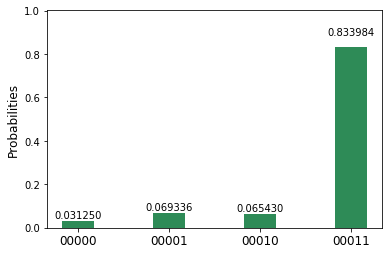

In [5]:
qasms = [{'qasm' : superdense_code}]
out = api.run_job(qasms,'real',1024,max_credits=3)
jobids=[out['id']]
results=combine_jobs(jobids, api, wait=5, timeout=240)
data=get_data(results,0)
plot_histogram(data)

The state with the highest probability should match the message that Alice encoded earlier. Mathematically:
- For a message of **00**: Bob received $|\psi_{00}\rangle = \frac{1}{\sqrt{2}}(|0_A 0_B\rangle + |1_A 1_B\rangle)$. Applying $CNOT$ gives: $\frac{1}{\sqrt{2}}(|0_A 0_B\rangle + |1_A 0_B\rangle)$. Applying $H$ on $q_A$ results in: $\frac{1}{\sqrt{2}}\frac{1}{\sqrt{2}}[(|0_A\rangle + |1_A\rangle)|0_B\rangle + (|0_A\rangle - |1_A\rangle)|0_B\rangle] = |0_A 0_B\rangle$ 
- For a message of **01**: Bob received $|\psi_{01}\rangle = \frac{1}{\sqrt{2}}(|1_A 0_B\rangle + |0_A 1_B\rangle)$. Applying $CNOT$ gives: $\frac{1}{\sqrt{2}}(|0_A 1_B\rangle)+ |1_A 1_B\rangle$. Applying $H$ on $q_A$ results in: $\frac{1}{\sqrt{2}}\frac{1}{\sqrt{2}}[(|0_A\rangle + |1_A\rangle)|1_B\rangle + (|0_A\rangle - |1_A\rangle)|1_B\rangle + (|0_A\rangle + |1_A\rangle)|1_B\rangle] = |0_A 1_B\rangle$ 
- For a message of **10**: Bob received $|\psi_{10}\rangle = \frac{1}{\sqrt{2}}(|0_A 0_B\rangle - |1_A 1_B\rangle)$. Applying $CNOT$ gives: $\frac{1}{\sqrt{2}}(|0_A 0_B\rangle - |1_A 0_B\rangle)$. Applying $H$ on $q_A$ results in: $\frac{1}{\sqrt{2}}\frac{1}{\sqrt{2}}[(|0_A\rangle + |1_A\rangle)|0_B\rangle - (|0_A\rangle - |1_A\rangle)|0_B\rangle] = |1_A 0_B\rangle$ 
- For a message of **11**: Bob received $|\psi_{11}\rangle = \frac{1}{\sqrt{2}}(- |1_A 0_B\rangle + |0_A 1_B\rangle $. Applying $CNOT$ gives: $\frac{1}{\sqrt{2}}(|0_A 1_B\rangle - |1_A 1_B\rangle)$. Applying $H$ on $q_A$ results in: $\frac{1}{\sqrt{2}}\frac{1}{\sqrt{2}}[(|0_A\rangle + |1_A\rangle)|1_B\rangle - (|0_A\rangle - |1_A\rangle)|1_B\rangle] = |1_A 1_B\rangle$ 